In [119]:
from ipywidgets import interact, fixed, IntSlider, FloatSlider
from skimage.morphology import dilation, square
from skimage.color import rgb2gray, rgb2hsv
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import cv2


In [120]:
from python_files.hough_transform_module import Hough
from python_files.sliding_window_module import SlidingWindow
from python_files.preprocessing_functions import crop_half, plot_images, gray_to_binary

## Read video

In [121]:
# read the first frame of the video and store it
vidcap = cv2.VideoCapture("Videos/LaneVideo.mp4")
success, frame = vidcap.read()

## Resize frame & convert to gray

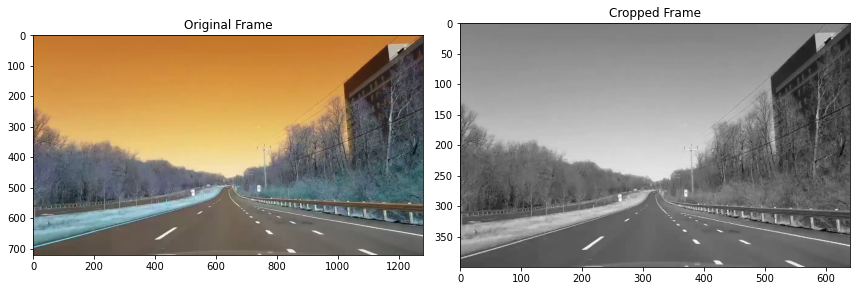

In [122]:
resized_frame = cv2.resize(frame, (640, 400))
gray_resized_frame = rgb2gray(resized_frame)
plot_images(frame, gray_resized_frame, "Original Frame", "Cropped Frame", cmap2='gray')

## Apply prespective transformation

In [123]:
H, W = gray_resized_frame.shape

In [140]:

# Initial parameters
bottom_width = int(W/8)
top_width = int(W/5)
vertical_position = int(H/2)
line_distance = int(H/5)
horizontal_position = int(W/2)

p1 = np.zeros((2, 1))
p2 = np.zeros((2, 1))
p3 = np.zeros((2, 1))
p4 = np.zeros((2, 1))

# Function to update the plot based on the slider values
def update_trapezoid(img, bottom_width, top_width, vertical_position, line_distance,
                     horizontal_position, rotation, line_distance1):
    global p1, p2, p3, p4
    # Convert degrees to radians for rotation
    theta_cw = np.radians(rotation)
    
    # update points based on sliders values
    x1 = horizontal_position - top_width / 2
    x2 = horizontal_position + top_width / 2
    x4 = horizontal_position - bottom_width / 2
    x3 = horizontal_position + bottom_width / 2
    y1 = vertical_position - line_distance1
    y2 = vertical_position - line_distance1
    y4 = vertical_position + line_distance
    y3 = vertical_position + line_distance
    
    # Rotation matrix for clockwise and counterclockwise rotation
    rot = np.array([[np.cos(theta_cw), -np.sin(theta_cw)],
                       [np.sin(theta_cw), np.cos(theta_cw)]])
    
    # Apply rotation transformation to trapezoid vertices
    p1 = np.dot(rot, np.array([[x1], [y1]]))
    p2 = np.dot(rot, np.array([[x2], [y2]]))
    p3 = np.dot(rot, np.array([[x3], [y3]]))
    p4 = np.dot(rot, np.array([[x4], [y4]]))
    pts = np.array([p1, p2, p3, p4])
    
    # Plot the rotated trapezoid
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.plot([p1[0], p2[0], p3[0], p4[0], p1[0]], [p1[1], p2[1], p3[1], p4[1], p1[1]], 'b-')
    plt.scatter(pts[:, 0], pts[:, 1], color=['red', 'blue', 'green', 'yellow'])
    plt.ylim(H, 0)
    plt.xlim(0, W)
    plt.show()

# Create sliders for controlling the trapezoid parameters and rotation angles
interact(update_trapezoid,
         img=fixed(gray_resized_frame),
         bottom_width=FloatSlider(min=1, max=W, step=0.1, value=370, description='Bottom Width:'),
         top_width=FloatSlider(min=1, max=W, step=0.1, value=120, description='Top Width:'),
         vertical_position=FloatSlider(min=1, max=H, step=0.1, value=310, description='Vertical Position:'),
         line_distance=FloatSlider(min=1, max=H, step=0.1, value=64, description='Line Distance:'),
         horizontal_position=FloatSlider(min=0, max=W, step=0.1, value=323, description='Horizontal Position:'),
         rotation=FloatSlider(min=-180, max=180, step=2, value=1.5, description='Rotation (degrees):'),
         line_distance1=FloatSlider(min=1, max=H, step=0.1, value=line_distance-100, description='Line Distance1:'),
         
        )


interactive(children=(FloatSlider(value=370.0, description='Bottom Width:', max=640.0, min=1.0), FloatSlider(v…

<function __main__.update_trapezoid(img, bottom_width, top_width, vertical_position, line_distance, horizontal_position, rotation, line_distance1)>

In [125]:
def perspective_transformation(img, pts_source):
        """Returns perspective transformation of an image."""
        if(len(img.shape) == 2):
                H, W = img.shape
        else:
                H, W, _ = img.shape
                
        # Define source points, points are defined as (col, row)
        d_top_left = (0, 0)
        d_top_right = (W-1, 0)
        d_bottom_left = (0, H - 1)
        d_bottom_right = (W - 1, H - 1)
        
        pts_destination = np.array([d_top_left, d_top_right, d_bottom_right, d_bottom_left], dtype=np.float32)
        
        # Get perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(pts_source, pts_destination)
        
        # Apply perspective transformation
        transformed_img = cv2.warpPerspective(img, matrix, (W, H))
        return transformed_img, matrix

In [126]:
pts_source = np.array([p1, p2, p3, p4], dtype=np.float32).reshape(4, 2)
transformed_img, matrix = perspective_transformation(gray_resized_frame, pts_source)

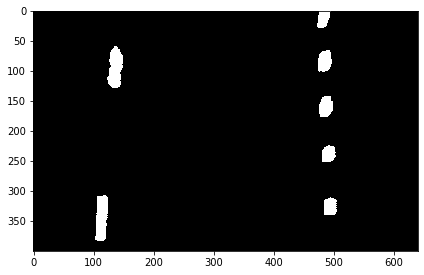

In [127]:
binary_frame = gray_to_binary(transformed_img)
io.imshow(binary_frame)
plt.show()

# Morphological operation

In [128]:
eroded_img = None
def apply_erosion_test(img, element_size):
    """Applies opening morphological operation."""
    global eroded_img
    
    vertical_kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))  # Adjust the kernel size as needed

    # Perform dilation to elongate the white rectangle vertically
    elongated_rectangle = cv2.dilate(img, vertical_kernel1, iterations=8)

    # Define the structuring element for the morphology operation (kernel)
    vertical_kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (element_size, 1))  # Adjust the kernel size as needed

    # Perform closing on the grayscale image
    eroded_img = cv2.morphologyEx(elongated_rectangle, cv2.MORPH_ERODE, vertical_kernel2)

    # Display the opened image
    plt.figure(figsize=(6, 6))
    plt.imshow(eroded_img, cmap='gray')
    plt.title(f'Morphological Opening (Element Size: {element_size})')
    plt.show()


# Create a slider for the element size parameter
element_size_slider = IntSlider(min=1, max=50, step=1, value=5, description='Element Size')

# Create the interactive widget
interact(apply_erosion_test, img=fixed(binary_frame), element_size=element_size_slider);    

interactive(children=(IntSlider(value=5, description='Element Size', max=50, min=1), Output()), _dom_classes=(…

# Hough Transform

In [129]:
hough_ = Hough(5, 200)

In [130]:
r1, theta1, r2, theta2 = hough_.get_polar_coorindates(eroded_img)
lane_mask_h = hough_.get_mask(eroded_img, r1, theta1, r2, theta2)

# Sliding Window

In [131]:
sw = SlidingWindow(50, 30)
lane_mask_sw = sw.get_mask(eroded_img)

# Inverse Perspective Transformation

In [132]:
def inv_perspective_transform(inv_frame, t_matrix, W, H):
    """Applies Inverse Perspective Transformation on a transformed frame."""
    inv_t_matrix= np.linalg.inv(t_matrix)
    frame = cv2.warpPerspective(inv_frame, inv_t_matrix, (W, H))
    return frame

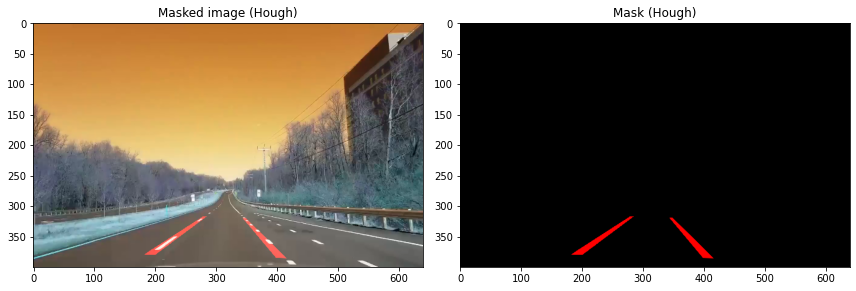

In [133]:
H, W, _ = lane_mask_h.shape
masked_img_h = np.copy(resized_frame)
inv_lanes_mask = inv_perspective_transform(lane_mask_h, matrix, W, H)
masked_img_h[:, :, 0] = np.maximum(masked_img_h[:, :, 0], inv_lanes_mask[:, :, 0])
plot_images(masked_img_h, inv_lanes_mask, "Masked image (Hough)", "Mask (Hough)")

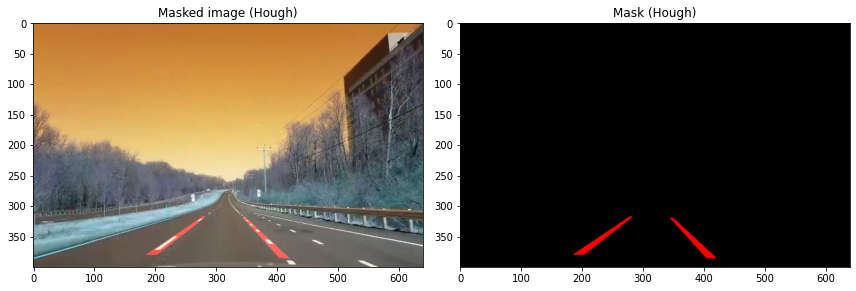

In [134]:
H, W, _ = lane_mask_sw.shape
masked_img_sw = np.copy(resized_frame)
inv_lanes_mask = inv_perspective_transform(lane_mask_sw, matrix, W, H)
masked_img_sw[:, :, 0] = np.maximum(masked_img_sw[:, :, 0], inv_lanes_mask[:, :, 0])
plot_images(masked_img_sw, inv_lanes_mask, "Masked image (Hough)", "Mask (Hough)")

# Hough transform PipeLine

In [135]:
def lane_detection_pipeline(video_path, algorithm):
    video = cv2.VideoCapture(video_path)
    if(algorithm == "hough"):
        model = Hough(5, 250)
    else:
        model = SlidingWindow(30, 30)
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        
        # resize image using the following dimensions 
        resized_frame = cv2.resize(frame, (640, 400))
        gray_resized_frame = rgb2gray(resized_frame)
            
        # apply Prespective transformation
        transformed_img, matrix = perspective_transformation(gray_resized_frame, pts_source)            
            
        # convert to binary
        binary_frame = gray_to_binary(transformed_img)
    
        # add morphological opeations if needed
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))  # Adjust the kernel size as needed

        # Perform dilation to elongate the white rectangle vertically
        elongated_rectangle = cv2.dilate(binary_frame, vertical_kernel, iterations=8)

        # Define the structuring element for the morphology operation (kernel)
        vertical_kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))  # Adjust the kernel size as needed

        # Perform erosion on the enlongated image
        eroded_img = cv2.morphologyEx(elongated_rectangle, cv2.MORPH_ERODE, vertical_kernel2)
        
        if(i % 4 == 0):   
            # apply hough transfomration
            if(algorithm == 'hough'):
                r1, theta1, r2, theta2 = model.get_polar_coorindates(eroded_img)
                lanes_mask = model.get_mask(eroded_img, r1, theta1, r2, theta2)
            else:
                lanes_mask = model.get_mask(eroded_img)

        # apply inverse prespective transform
        H, W, _ = lanes_mask.shape
        inv_lanes_mask = inv_perspective_transform(lanes_mask, matrix, W, H)
        
        # add mask to the original frame
        resized_frame = cv2.addWeighted(resized_frame, 0.8, inv_lanes_mask, 1, 0)

        i += 1
    
        # Display the frame
        cv2.imshow('Video Player', resized_frame)
        cv2.imshow('perspective transformation', eroded_img)
        cv2.imshow('mask', lanes_mask)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Release resources
    video.release()
    cv2.destroyAllWindows()

In [136]:
%time lane_detection_pipeline('Videos/LaneVideo.mp4', "hough")

Wall time: 2.44 s


In [137]:
%time lane_detection_pipeline('Videos/LaneVideo.mp4', "slidingWindow")

Wall time: 43.4 s


# **Done!**